In [1]:
import json, random, time
import numpy as np
from pprint import pprint
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import os
import re
from nltk.corpus import stopwords
import pickle
import pylcs
np.set_printoptions(precision=4)

In [2]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [36]:
txt_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_first_release.json", "r"))
img_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_first_release.json", "r"))

print(Counter([txt_dataset[k]['split'] for k in txt_dataset]))
print(len(set([txt_dataset[k]['Guid'] for k in txt_dataset])))

print(Counter([img_dataset[k]['split'] for k in img_dataset]))
print(Counter([img_dataset[k]['Qcate'] for k in img_dataset]))
print(Counter([img_dataset[k]['Qcate'] for k in img_dataset if img_dataset[k]['split'] == 'test']))
print(len(set([img_dataset[k]['Guid'] for k in img_dataset])))

Counter({'train': 17812, 'test': 4076, 'val': 2455})
24343
Counter({'train': 18954, 'test': 3464, 'val': 2511})
Counter({'YesNo': 8255, 'Others': 6470, 'choose': 5201, 'number': 2318, 'color': 2058, 'shape': 627})
Counter({'Others': 1058, 'choose': 981, 'YesNo': 935, 'color': 228, 'number': 200, 'shape': 62})
24929


Q_txt_data 24343
A_txt_data 20267
Q_img_data 24929
A_img_data 21465
Q_txt_data 24.35410590313437 9.593644956079919
A_txt_data 9.662900281245374 12.471250670668253
Q_img_data 23.55954911949938 7.447054212504771
A_img_data 21.381271837875612 7.512584895289815


'\nQ_txt_data 24343\nA_txt_data 40153\nQ_img_data 22423\nA_img_data 36351\nQ_txt_data 24.35410590313437 9.593644956079919\nA_txt_data 15.775060393992977 14.363007224350644\nQ_img_data 23.575123756856797 7.447930428251592\nA_img_data 21.106929658056174 7.885119426596238\n'

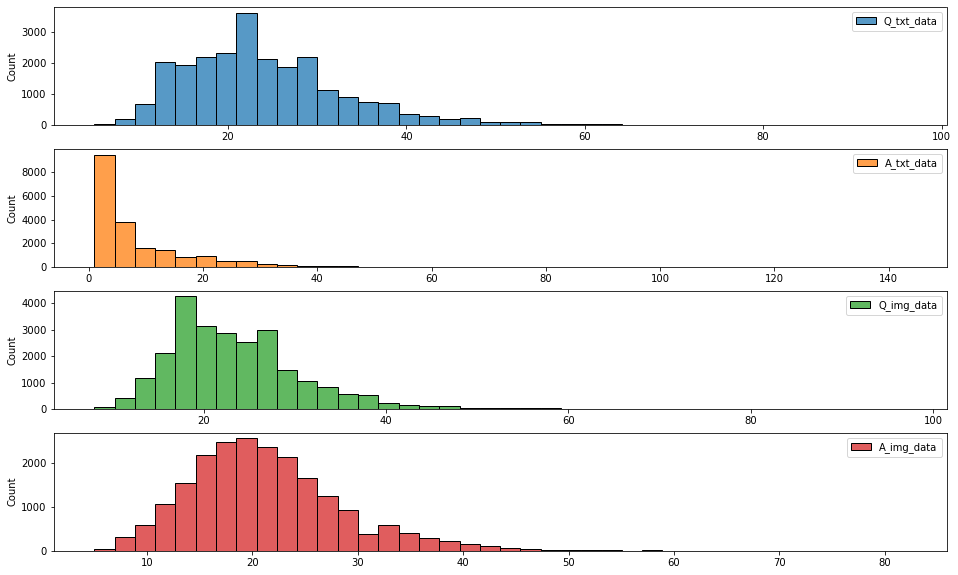

In [33]:
### Comparison of length distribution of snippets: 
# with pos snippets || with neg snippets for img data || with neg snippets for txt data
snippet_lengths = {'Q_txt_data': [], 'A_txt_data': [], 'Q_img_data': [], 'A_img_data': []}
for k in txt_dataset:
    snippet_lengths['Q_txt_data'].append(len(tokenizer.tokenize(txt_dataset[k]['Q'])))
    snippet_lengths['A_txt_data'].extend([len(tokenizer.tokenize(a)) for a in txt_dataset[k]['A'] if not txt_dataset[k]['split'] == 'test'])
for k in img_dataset:
    snippet_lengths['Q_img_data'].append(len(tokenizer.tokenize(img_dataset[k]['Q'])))
    snippet_lengths['A_img_data'].extend([len(tokenizer.tokenize(a)) for a in img_dataset[k]['A'] if not img_dataset[k]['split'] == 'test'])
        
for k in snippet_lengths:
    print(k, len(snippet_lengths[k]))
for k in snippet_lengths:
    print(k, np.mean(snippet_lengths[k]), np.std(snippet_lengths[k]))
    
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(4, 1, sharex=False, figsize=(16,10))
for i, k, color in zip(range(4), list(snippet_lengths.keys()), colors[:4]):
    ax = axes[i]
    #ax.set(yscale="log")
    sns.histplot(snippet_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()
'''
Q_txt_data 24343
A_txt_data 40153
Q_img_data 22423
A_img_data 36351
Q_txt_data 24.35410590313437 9.593644956079919
A_txt_data 15.775060393992977 14.363007224350644
Q_img_data 23.575123756856797 7.447930428251592
A_img_data 21.106929658056174 7.885119426596238
'''

In [37]:
print("\nImg data, num(img_posFacts): ")
x = [len(img_dataset[k]['img_posFacts']) for k in img_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\nImg data, num(img_negFacts): ")
x = [len(img_dataset[k]['img_negFacts']) for k in img_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\nImg data, num(txt_negFacts): ")
x = [len(img_dataset[k]['txt_negFacts']) for k in img_dataset]
print(Counter(x))
print(np.sum(x))
print(np.mean(x), np.max(x), np.min(x))

'''Img data, num(img_posFacts): 
Counter({1: 12588, 2: 9835})
1.4386121393212326 2 1

Img data, num(img_negFacts): 
Counter({16: 21403, 13: 704, 12: 89, 15: 74, 14: 71, 11: 62, 7: 11, 10: 4, 8: 3, 9: 2})
15.859296258306204 16 7

Img data, num(txt_negFacts): 
Counter({16: 20622, 0: 134, 13: 130, 14: 120, 10: 119, 15: 119, 12: 118, 1: 118, 8: 115, 6: 113, 11: 113, 2: 106, 5: 104, 7: 104, 9: 97, 4: 96, 3: 95})
343674
15.326851893145431 16 0
'''


Img data, num(img_posFacts): 
Counter({1: 13988, 2: 10941})
1.4388864374824502 2 1

Img data, num(img_negFacts): 
Counter({16: 23785, 13: 774, 12: 115, 15: 84, 14: 78, 11: 68, 7: 14, 9: 4, 10: 4, 8: 3})
15.857033976493241 16 7

Img data, num(txt_negFacts): 
Counter({16: 22918, 0: 149, 13: 141, 15: 137, 14: 136, 12: 136, 1: 131, 10: 129, 6: 129, 8: 128, 11: 127, 5: 118, 2: 116, 7: 113, 9: 109, 3: 106, 4: 106})
382064
15.326086084479924 16 0


'Img data, num(img_posFacts): \nCounter({1: 12588, 2: 9835})\n1.4386121393212326 2 1\n\nImg data, num(img_negFacts): \nCounter({16: 21403, 13: 704, 12: 89, 15: 74, 14: 71, 11: 62, 7: 11, 10: 4, 8: 3, 9: 2})\n15.859296258306204 16 7\n\nImg data, num(txt_negFacts): \nCounter({16: 20622, 0: 134, 13: 130, 14: 120, 10: 119, 15: 119, 12: 118, 1: 118, 8: 115, 6: 113, 11: 113, 2: 106, 5: 104, 7: 104, 9: 97, 4: 96, 3: 95})\n343674\n15.326851893145431 16 0\n'

In [38]:
print("\nImg data, num(img_posFacts): ")
x = [len(img_dataset[k]['img_posFacts']) for k in img_dataset if img_dataset[k]['split'] == 'test']
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\nImg data, num(img_negFacts): ")
x = [len(img_dataset[k]['img_negFacts']) for k in img_dataset if img_dataset[k]['split'] == 'test']
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\nImg data, num(txt_negFacts): ")
x = [len(img_dataset[k]['txt_negFacts']) for k in img_dataset if img_dataset[k]['split'] == 'test']
print(Counter(x))
print(np.sum(x))
print(np.mean(x), np.max(x), np.min(x))


Img data, num(img_posFacts): 
Counter({1: 1961, 2: 1503})
1.4338914549653579 2 1

Img data, num(img_negFacts): 
Counter({16: 3309, 13: 104, 12: 20, 11: 11, 14: 10, 15: 8, 7: 1, 10: 1})
15.858545034642033 16 7

Img data, num(txt_negFacts): 
Counter({16: 3162, 0: 24, 2: 24, 6: 24, 10: 23, 4: 23, 13: 22, 11: 21, 1: 21, 3: 18, 7: 17, 8: 17, 9: 14, 14: 14, 12: 14, 5: 13, 15: 13})
52703
15.214491916859123 16 0


In [39]:
print("\ntxt data, num(txt_posFacts): ")
x = [len(txt_dataset[k]['txt_posFacts']) for k in txt_dataset]
print(np.sum(x))
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\ntxt data, num(img_negFacts): ")
x = [len(txt_dataset[k]['img_negFacts']) for k in txt_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\ntxt data, num(txt_negFacts): ")
x = [len(txt_dataset[k]['txt_negFacts']) for k in txt_dataset]
print(np.sum(x))
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

'''
txt data, num(txt_posFacts): 
49628
Counter({2: 23442, 3: 852, 4: 45, 1: 3, 5: 1})
2.0386969560037795 5 1

txt data, num(img_negFacts): 
Counter({16: 13773, 5: 898, 6: 840, 7: 783, 1: 759, 8: 748, 9: 723, 2: 691, 3: 690, 10: 672, 4: 637, 11: 632, 12: 550, 13: 549, 14: 530, 15: 506, 0: 362})
12.202604444809596 16 0

txt data, num(txt_negFacts): 
356117
Counter({16: 19109, 10: 482, 8: 479, 7: 472, 9: 467, 13: 465, 11: 442, 12: 438, 6: 438, 15: 430, 5: 427, 14: 412, 4: 226, 3: 54, 2: 2})
14.629133631844883 16 2
'''


txt data, num(txt_posFacts): 
49520
Counter({2: 23383, 3: 832, 1: 85, 4: 42, 5: 1})
2.034260362321817 5 1

txt data, num(img_negFacts): 
Counter({16: 13773, 5: 898, 6: 840, 7: 783, 1: 759, 8: 748, 9: 723, 2: 691, 3: 690, 10: 672, 4: 637, 11: 632, 12: 550, 13: 549, 14: 530, 15: 506, 0: 362})
12.202604444809596 16 0

txt data, num(txt_negFacts): 
356113
Counter({16: 19105, 10: 482, 8: 479, 7: 472, 9: 467, 13: 465, 11: 442, 12: 438, 6: 438, 15: 434, 5: 427, 14: 412, 4: 226, 3: 54, 2: 2})
14.628969313560367 16 2


'\ntxt data, num(txt_posFacts): \n49628\nCounter({2: 23442, 3: 852, 4: 45, 1: 3, 5: 1})\n2.0386969560037795 5 1\n\ntxt data, num(img_negFacts): \nCounter({16: 13773, 5: 898, 6: 840, 7: 783, 1: 759, 8: 748, 9: 723, 2: 691, 3: 690, 10: 672, 4: 637, 11: 632, 12: 550, 13: 549, 14: 530, 15: 506, 0: 362})\n12.202604444809596 16 0\n\ntxt data, num(txt_negFacts): \n356117\nCounter({16: 19109, 10: 482, 8: 479, 7: 472, 9: 467, 13: 465, 11: 442, 12: 438, 6: 438, 15: 430, 5: 427, 14: 412, 4: 226, 3: 54, 2: 2})\n14.629133631844883 16 2\n'

In [40]:
print("\ntxt data, num(txt_posFacts): ")
x = [len(txt_dataset[k]['txt_posFacts']) for k in txt_dataset if txt_dataset[k]['split'] == 'test']
print(np.sum(x))
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\ntxt data, num(img_negFacts): ")
x = [len(txt_dataset[k]['img_negFacts']) for k in txt_dataset if txt_dataset[k]['split'] == 'test']
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\ntxt data, num(txt_negFacts): ")
x = [len(txt_dataset[k]['txt_negFacts']) for k in txt_dataset if txt_dataset[k]['split'] == 'test']
print(np.sum(x))
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))


txt data, num(txt_posFacts): 
8292
Counter({2: 3931, 3: 132, 4: 7, 1: 6})
2.0343473994111876 4 1

txt data, num(img_negFacts): 
Counter({16: 2276, 5: 157, 8: 139, 1: 138, 6: 125, 2: 123, 7: 118, 3: 117, 10: 114, 9: 112, 11: 110, 13: 107, 4: 104, 15: 98, 12: 97, 14: 89, 0: 52})
12.185721295387635 16 0

txt data, num(txt_negFacts): 
59704
Counter({16: 3180, 10: 88, 13: 83, 14: 82, 12: 80, 15: 79, 11: 79, 7: 77, 9: 74, 6: 72, 8: 70, 5: 64, 4: 42, 3: 6})
14.647693817468106 16 3


In [25]:
img_topics = Counter([img_dataset[k]['topic'] for k in img_dataset])
print(img_topics.most_common(20))

[('Other', 2311), ('streets', 2238), ('plaza', 1278), ('mushroom', 807), ('downtown', 805), ('bird', 773), ('car', 699), ('tourist attractions', 612), ('vista', 599), ('civic center', 570), ('Christ Church Cathedral', 558), ('public art', 546), ('museum', 520), ('world expo pavilion', 505), ('tech institute', 499), ('flora', 486), ('Neoclassicism art', 477), ('modern artwork', 461), ('strange architecture', 458), ('olympics opening ceremony', 453)]


pos_imgs 35870
neg_imgs_for_img 395300
neg_imgs_for_txt 297048
pos_imgs 23.829383886255926 17.65052419741056
neg_imgs_for_img 23.726104224639514 18.630041650139287
neg_imgs_for_txt 22.485931566615495 21.951410201154395


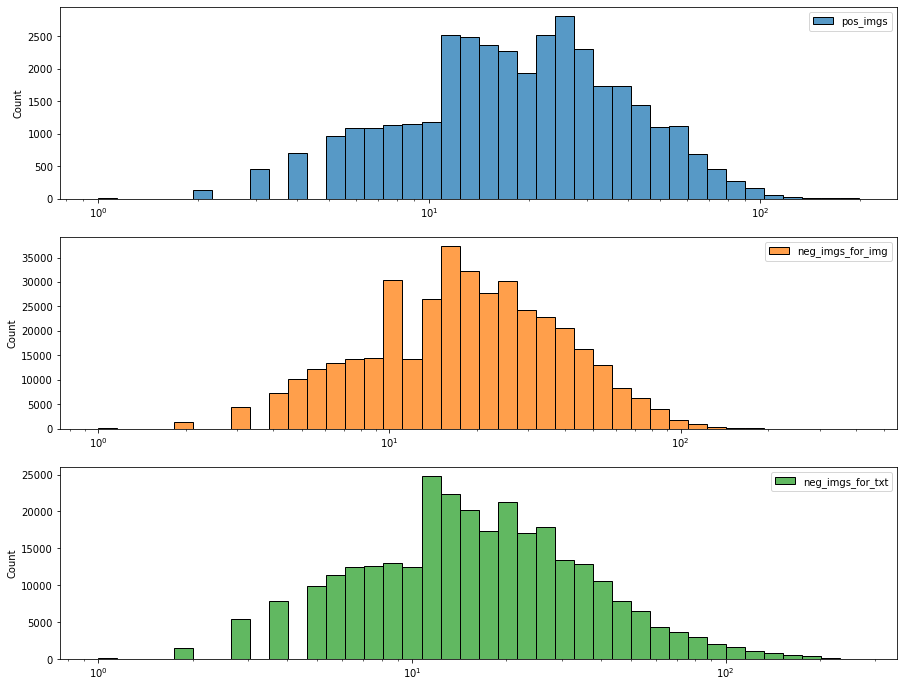

In [26]:
### Comparison of length distribution of img captions: 
# with pos imgs || with neg imgs for img data || with neg imgs for txt data
cap_lengths = {'pos_imgs': [], 'neg_imgs_for_img': [], 'neg_imgs_for_txt': []}
for k in img_dataset:
    for i in img_dataset[k]['img_posFacts']:
        cap_lengths['pos_imgs'].append(len(tokenizer.tokenize(i['caption'].strip())))
    for i in img_dataset[k]['img_negFacts']:
        cap_lengths['neg_imgs_for_img'].append(len(tokenizer.tokenize(i['caption'].strip())))
for k in txt_dataset:
    for i in txt_dataset[k]['img_negFacts']:
        cap_lengths['neg_imgs_for_txt'].append(len(tokenizer.tokenize(i['caption'].strip())))
        
for k in cap_lengths:
    print(k, len(cap_lengths[k]))
for k in cap_lengths:
    print(k, np.mean(cap_lengths[k]), np.std(cap_lengths[k]))

colors = sns.color_palette("tab10")
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15,12))
for i, k, color in zip(range(3), list(cap_lengths.keys()), colors[:3]):
    ax = axes[i]
    ax.set(xscale="log")
    sns.histplot(cap_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()

pos_snippets 49628
neg_snippets_for_img 382064
neg_snippets_for_txt 356117
pos_snippets 65.21256145724188 19.347038651791905
neg_snippets_for_img 49.76232254282005 15.325313181559885
neg_snippets_for_txt 53.71806456866704 17.5997685882277


'\npos_snippets 49628\nneg_snippets_for_img 343674\nneg_snippets_for_txt 356117\npos_snippets 65.21256145724188 19.347038651791905\nneg_snippets_for_img 49.76683426735802 15.334392825559785\nneg_snippets_for_txt 53.71806456866704 17.5997685882277\n'

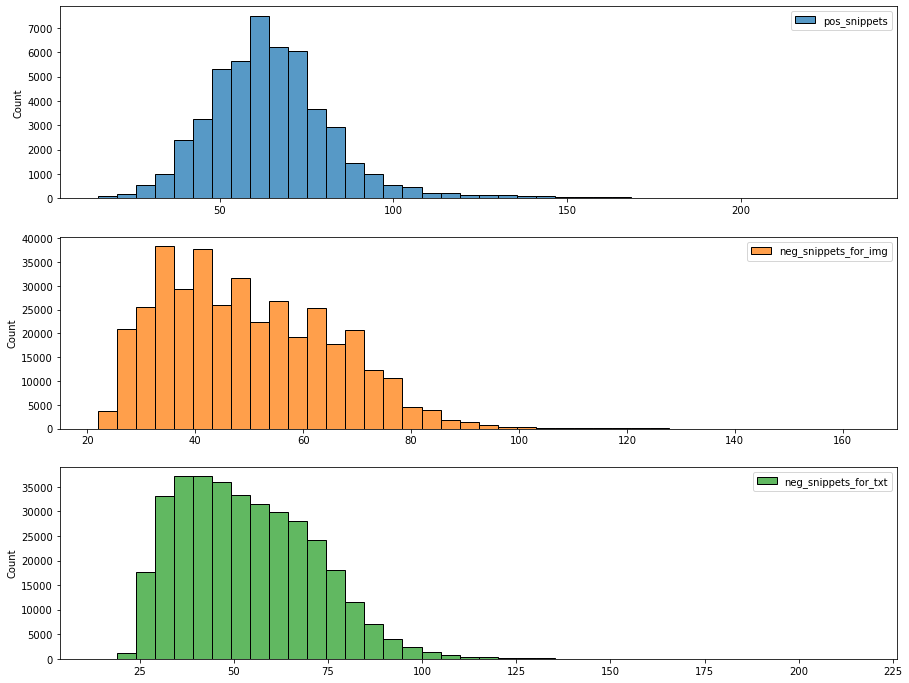

In [27]:
### Comparison of length distribution of snippets: 
# with pos snippets || with neg snippets for img data || with neg snippets for txt data
snippet_lengths = {'pos_snippets': [], 'neg_snippets_for_img': [], 'neg_snippets_for_txt': []}
for k in txt_dataset:
    for f in txt_dataset[k]['txt_posFacts']:
        snippet_lengths['pos_snippets'].append(len(tokenizer.tokenize(f['fact'])))
    for f in txt_dataset[k]['txt_negFacts']:
        snippet_lengths['neg_snippets_for_txt'].append(len(tokenizer.tokenize(f['fact'])))
for k in img_dataset:
    for f in img_dataset[k]['txt_negFacts']:
        snippet_lengths['neg_snippets_for_img'].append(len(tokenizer.tokenize(f['fact'])))
        
for k in snippet_lengths:
    print(k, len(snippet_lengths[k]))
for k in snippet_lengths:
    print(k, np.mean(snippet_lengths[k]), np.std(snippet_lengths[k]))
    
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15,12))
for i, k, color in zip(range(3), list(snippet_lengths.keys()), colors[:3]):
    ax = axes[i]
    #ax.set(yscale="log")
    sns.histplot(snippet_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()
    
'''
pos_snippets 49628
neg_snippets_for_img 343674
neg_snippets_for_txt 356117
pos_snippets 65.21256145724188 19.347038651791905
neg_snippets_for_img 49.76683426735802 15.334392825559785
neg_snippets_for_txt 53.71806456866704 17.5997685882277
'''

In [28]:
img_dataset['0'].keys()

dict_keys(['Q', 'A', 'Qtype', 'topic', 'split', 'Qcate', 'Guid', 'img_posFacts', 'img_negFacts', 'txt_negFacts'])

### Filter Lexical Overlap Baseline

In [11]:
def compute_retrieval_metrics(pred, gth):
    common = len(set(pred).intersection(gth))
    RE = common / len(gth)
    PR = common / len(pred)
    F1 = 2*PR*RE / (PR + RE + 1e-5)
    return F1, RE, PR

# For the purpose of measuring token-level overlap
### Processing: only did stopwords removal + tokenization
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

def compute_vqa_metrics_for_filter_lexical_baseline(cands, a):
    if len(cands) == 0: return (0,0,0)
    remove_stop_a = pattern.sub('', a)
    bow_a = tokenizer.tokenize(remove_stop_a) #normalize_text(a).split()
    
    F1 = []
    EM = 0
    RE = []
    PR = []
    for c in cands:
        remove_stop_c = pattern.sub('', c)
        bow_c = tokenizer.tokenize(remove_stop_c) #normalize_text(c).split()
        cand_length = len(bow_c)
        if bow_c == bow_a:
            EM = 1
        common = Counter(bow_a) & Counter(bow_c)
        num_same = sum(common.values())
        if num_same == 0:
            return (0,0,0,0,0, cand_length)
        precision = 1.0 * num_same / len(bow_c)
        recall = 1.0 * num_same / len(bow_a)
        RE.append(recall)
        PR.append(precision)

        f1 = 2*precision*recall / (precision + recall + 1e-5)
        F1.append(f1)
    
    PR_avg = np.mean(PR)
    RE_avg = np.mean(RE)
    F1_avg = np.mean(F1)
    F1_max = np.max(F1)
    return (F1_avg, F1_max, EM, RE_avg, PR_avg, cand_length)

In [12]:
# For each sample, compute overlap metrics between Q and all facts respectively
# Only for testing set

guid2posMetrics = {}
guid2negMetrics = {}
zero_pos = 0
count = 0
counter = []
for k in txt_dataset:
    if not txt_dataset[k]['split'] == 'test': continue
    count += 1
    if count%1000 == 0: print(k)
    q = txt_dataset[k]['Q']
    guid = txt_dataset[k]['Guid']
    guid2posMetrics[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': []}
    guid2negMetrics[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': []} #, 'RE_aug_by_len_bonus': []}


    txt_posFacts = txt_dataset[k]['txt_posFacts']
    if len(txt_posFacts) == 0: 
        zero_pos += 1
        continue
    for f in txt_posFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics_for_filter_lexical_baseline([f['fact']], q)
        lcs = pylcs.lcs2(q, f['fact'])
        lcs_f = lcs / len(f['fact'])
        lcs_q = lcs / len(q)
        guid2posMetrics[guid]['F1'].append(F1)
        guid2posMetrics[guid]['RE'].append(RE)
        guid2posMetrics[guid]['PR'].append(PR)
        guid2posMetrics[guid]['lcs_q'].append(lcs_q)
        guid2posMetrics[guid]['lcs_f'].append(lcs_f)
    
    txt_negFacts = txt_dataset[k]['txt_negFacts']
    counter.append(len(txt_negFacts))
    for d in txt_negFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics_for_filter_lexical_baseline([d['fact']], q)
        lcs = pylcs.lcs2(q, d['fact'])
        lcs_f = lcs / len(d['fact'])
        lcs_q = lcs / len(q)
        guid2negMetrics[guid]['F1'].append(F1)
        guid2negMetrics[guid]['RE'].append(RE)
        guid2negMetrics[guid]['PR'].append(PR)
        guid2negMetrics[guid]['lcs_q'].append(lcs_q)
        guid2negMetrics[guid]['lcs_f'].append(lcs_f)
        
        #len_bonus = (cand_length - 45) * 0.01 if cand_length > 45 else 0.0
        #guid2negMetrics[guid]['RE_aug_by_len_bonus'].append(RE + len_bonus)

assert set(guid2posMetrics.keys()) == set(guid2negMetrics.keys())
print(zero_pos)
print(count)
print(Counter(counter))

4020
13151
19050
24885
0
4076
Counter({16: 3180, 10: 88, 13: 83, 14: 82, 12: 80, 15: 79, 11: 79, 7: 77, 9: 74, 6: 72, 8: 70, 5: 64, 4: 42, 3: 6})


In [13]:
# For each sample, compute overlap metrics between Q and all facts respectively
# txt data, and their negative imgs.
# Only for testing set

guid2negImgMetrics = {}
count = 0
counter = []
for k in txt_dataset:
    if not txt_dataset[k]['split'] == 'test': continue
    count += 1
    if count%1000 == 0: print(count)
    q = txt_dataset[k]['Q']
    guid = txt_dataset[k]['Guid']
    guid2negImgMetrics[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': []} #, 'RE_aug_by_len_bonus': []}

    img_negFacts = txt_dataset[k]['img_negFacts']
    counter.append(len(img_negFacts))
    for d in img_negFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics_for_filter_lexical_baseline([d['caption']], q)
        lcs = pylcs.lcs2(q, d['caption'])
        lcs_f = lcs / len(d['caption'])
        lcs_q = lcs / len(q)
        guid2negImgMetrics[guid]['F1'].append(F1)
        guid2negImgMetrics[guid]['RE'].append(RE)
        guid2negImgMetrics[guid]['PR'].append(PR)
        guid2negImgMetrics[guid]['lcs_q'].append(lcs_q)
        guid2negImgMetrics[guid]['lcs_f'].append(lcs_f)
        
        #len_bonus = (cand_length - 10) * (-0.015) if cand_length > 10 else 0.0
        #guid2negImgMetrics[guid]['RE_aug_by_len_bonus'].append(RE + len_bonus)
        
assert set(guid2negMetrics.keys()) == set(guid2negImgMetrics.keys())
print(count)
print(Counter(counter))

1000
2000
3000
4000
4076
Counter({16: 2276, 5: 157, 8: 139, 1: 138, 6: 125, 2: 123, 7: 118, 3: 117, 10: 114, 9: 112, 11: 110, 13: 107, 4: 104, 15: 98, 12: 97, 14: 89, 0: 52})


In [14]:
# For each sample, compute overlap metrics between Q and all facts respectively
# img data, and their negative snippets. 
# Only for testing set

guid2negMetrics_img_data = {}
count = 0
counter = []

for k in img_dataset:
    if not img_dataset[k]['split'] == 'test': continue
    count += 1
    if count%1000 == 0: print(count)
    q = img_dataset[k]['Q']
    guid = img_dataset[k]['Guid']
    guid2negMetrics_img_data[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': []} #, 'RE_aug_by_len_bonus': []}
    
    txt_negFacts = img_dataset[k]['txt_negFacts']
    counter.append(len(txt_negFacts))
    for d in txt_negFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics_for_filter_lexical_baseline([d['fact']], q)
        lcs = pylcs.lcs2(q, d['fact'])
        lcs_f = lcs / len(d['fact'])
        lcs_q = lcs / len(q)
        guid2negMetrics_img_data[guid]['F1'].append(F1)
        guid2negMetrics_img_data[guid]['RE'].append(RE)
        guid2negMetrics_img_data[guid]['PR'].append(PR)
        guid2negMetrics_img_data[guid]['lcs_q'].append(lcs_q)
        guid2negMetrics_img_data[guid]['lcs_f'].append(lcs_f)
        
        #len_bonus = (cand_length - 43) * 0.02 if cand_length > 43 else 0.0
        #guid2negMetrics_img_data[guid]['RE_aug_by_len_bonus'].append(RE + len_bonus)

print(count)
print(Counter(counter))

1000
2000
3000
3464
Counter({16: 3162, 0: 24, 2: 24, 6: 24, 10: 23, 4: 23, 13: 22, 11: 21, 1: 21, 3: 18, 7: 17, 8: 17, 9: 14, 14: 14, 12: 14, 5: 13, 15: 13})


In [15]:
# For each sample, compute overlap metrics between Q and all facts respectively
# img data, and their negative imgs. 
# Prefer shorter neg img captions

guid2negImgMetrics_img_data = {}
guid2posImgMetrics_img_data = {}
count = 0
counter = []
for k in img_dataset:
    if not img_dataset[k]['split'] == 'test': continue
    count += 1
    if count%1000 == 0: print(count)
    q = img_dataset[k]['Q']
    guid = img_dataset[k]['Guid']
    guid2posImgMetrics_img_data[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': []}
    guid2negImgMetrics_img_data[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': []} #, 'RE_aug_by_len_bonus': []}
    
    img_posFacts = img_dataset[k]['img_posFacts']
    for d in img_posFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics_for_filter_lexical_baseline([d['caption']], q)
        lcs = pylcs.lcs2(q, d['caption'])
        lcs_f = lcs / len(d['caption'])
        lcs_q = lcs / len(q)
        guid2posImgMetrics_img_data[guid]['F1'].append(F1)
        guid2posImgMetrics_img_data[guid]['RE'].append(RE)
        guid2posImgMetrics_img_data[guid]['PR'].append(PR)
        guid2posImgMetrics_img_data[guid]['lcs_q'].append(lcs_q)
        guid2posImgMetrics_img_data[guid]['lcs_f'].append(lcs_f)
        
    img_negFacts = img_dataset[k]['img_negFacts']
    counter.append(len(img_negFacts))
    for d in img_negFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics_for_filter_lexical_baseline([d['caption']], q)
        lcs = pylcs.lcs2(q, d['caption'])
        lcs_f = lcs / len(d['caption'])
        lcs_q = lcs / len(q)
        guid2negImgMetrics_img_data[guid]['F1'].append(F1)
        guid2negImgMetrics_img_data[guid]['RE'].append(RE)
        guid2negImgMetrics_img_data[guid]['PR'].append(PR)
        guid2negImgMetrics_img_data[guid]['lcs_q'].append(lcs_q)
        guid2negImgMetrics_img_data[guid]['lcs_f'].append(lcs_f)
        
        #len_bonus = (cand_length - 10) * (-0.01) if cand_length > 10 else 0.0
        #guid2negImgMetrics_img_data[guid]['RE_aug_by_len_bonus'].append(RE + len_bonus)
        
assert set(guid2negImgMetrics_img_data.keys()) == set(guid2negMetrics_img_data.keys()) == set(guid2posImgMetrics_img_data.keys())
print(count)
print(Counter(counter))

1000
2000
3000
3464
Counter({16: 3309, 13: 104, 12: 20, 11: 11, 14: 10, 15: 8, 7: 1, 10: 1})


In [60]:
guid = random.sample(list(guid2negMetrics.keys()), 1)[0]
print(guid2posMetrics[guid]['RE'])
print(guid2negMetrics[guid]['RE'])
#print(guid2negMetrics_img_data[guid]['RE'])

[0.6, 0.3333333333333333]
[0.4666666666666667, 0.3333333333333333, 0.26666666666666666, 0.26666666666666666, 0.3333333333333333, 0.3333333333333333, 0.13333333333333333, 0.26666666666666666, 0.26666666666666666, 0.06666666666666667, 0.13333333333333333, 0.2, 0.2, 0.2, 0.2, 0.2]


In [16]:
# randomly break ties
def argmax(n, L):
    l = copy.deepcopy(L)
    assert n <= len(l)
    result = []
    while len(result) < n:
        m = np.max(l)
        idx = random.choice([i for i in range(len(l)) if l[i] == m])
        result.append(idx)
        l[idx] = - 10000
    return result

In [17]:
# Performance of top2<m> lexical overlap baseline, txt data, known modality 
assert len(guid2posMetrics) == len(guid2negMetrics)
print(len(guid2posMetrics))
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for i in range(10):
        for guid in guid2posMetrics:
            f_scores = guid2posMetrics[guid][m]
            all_scores = np.array((f_scores + guid2negMetrics[guid][m])[:16])
            pred = argmax(2, all_scores)
            gth = range(len(guid2posMetrics[guid][m]))
            F1, RE, PR = compute_retrieval_metrics(pred, gth)
            F1s.append(F1)
            REs.append(RE)
            PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

4076
F1
   F1 =  0.4518568863061137
   RE =  0.45004906771344455
   PR =  0.45464916584887144
RE
   F1 =  0.6020817721075272
   RE =  0.5994336768073275
   PR =  0.6061457311089303
PR
   F1 =  0.35775374850396263
   RE =  0.3563460909388289
   PR =  0.3599239450441609
lcs_q
   F1 =  0.580699066026843
   RE =  0.5779685966633955
   PR =  0.5848871442590775
lcs_f
   F1 =  0.4209976384055774
   RE =  0.41921000981354267
   PR =  0.4237487733071639


In [18]:
# Performance of top2<m> lexical overlap baseline, txt data, UNknown modality 
assert len(guid2posMetrics) == len(guid2negMetrics) == len(guid2negImgMetrics)
print(len(guid2posMetrics))
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for i in range(10):
        for guid in guid2posMetrics:
            f_scores = guid2posMetrics[guid][m]
            all_scores = np.array((f_scores + guid2negMetrics[guid][m])[:16] + guid2negImgMetrics[guid][m])
            pred = argmax(2, all_scores)
            gth = range(len(guid2posMetrics[guid][m]))
            F1, RE, PR = compute_retrieval_metrics(pred, gth)
            F1s.append(F1)
            REs.append(RE)
            PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

4076
F1
   F1 =  0.3345776798011223
   RE =  0.3334355577363428
   PR =  0.33635917566241413
RE
   F1 =  0.5834279413778175
   RE =  0.5808492803402028
   PR =  0.5873773307163886
PR
   F1 =  0.138531640318577
   RE =  0.13806427870461235
   PR =  0.13926643768400393
lcs_q
   F1 =  0.5459887336855423
   RE =  0.5435966633954857
   PR =  0.5496687929342493
lcs_f
   F1 =  0.11485668795848082
   RE =  0.11458946679751389
   PR =  0.11526005888125614


In [19]:
# Performance of top2<m> lexical overlap baseline, img data, known modality 
assert len(guid2posImgMetrics_img_data) == len(guid2negImgMetrics_img_data)
print(len(guid2posImgMetrics_img_data))
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for i in range(10):
        for guid in guid2posImgMetrics_img_data:
            f_scores = guid2posImgMetrics_img_data[guid][m]
            all_scores = np.array(f_scores + guid2negImgMetrics_img_data[guid][m])[:16]
            try: pred = argmax(2, all_scores)
            except: print(all_scores)
            gth = range(len(guid2posImgMetrics_img_data[guid][m]))
            F1, RE, PR = compute_retrieval_metrics(pred, gth)
            F1s.append(F1)
            REs.append(RE)
            PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

3464
F1
   F1 =  0.5755927072708241
   RE =  0.7312644341801385
   PR =  0.4977627020785219
RE
   F1 =  0.570054797741281
   RE =  0.7248123556581986
   PR =  0.49268187066974595
PR
   F1 =  0.4893777866567357
   RE =  0.6297199769053118
   PR =  0.4192118937644342
lcs_q
   F1 =  0.560326250829386
   RE =  0.7095409930715936
   PR =  0.48572459584295613
lcs_f
   F1 =  0.4154656243814982
   RE =  0.5315098152424942
   PR =  0.3574480369515012


In [20]:
# Performance of top2<m> lexical overlap baseline, img data, UNknown modality 
assert len(guid2posImgMetrics_img_data) == len(guid2negMetrics_img_data) == len(guid2negImgMetrics_img_data)
print(len(guid2posImgMetrics_img_data))
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for i in range(10):
        for guid in guid2posImgMetrics_img_data:
            f_scores = guid2posImgMetrics_img_data[guid][m]
            all_scores = np.array((f_scores + guid2negImgMetrics_img_data[guid][m])[:16] + guid2negMetrics_img_data[guid][m])
            pred = all_scores.argsort()[-2:][::-1]
            gth = range(len(guid2posImgMetrics_img_data[guid][m]))
            F1, RE, PR = compute_retrieval_metrics(pred, gth)
            F1s.append(F1)
            REs.append(RE)
            PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

3464
F1
   F1 =  0.44827434599511484
   RE =  0.5705831408775982
   PR =  0.38712471131639725
RE
   F1 =  0.344204605324203
   RE =  0.4437066974595843
   PR =  0.29445727482678985
PR
   F1 =  0.42373634849668984
   RE =  0.5411374133949192
   PR =  0.365040415704388
lcs_q
   F1 =  0.37345768926832534
   RE =  0.47372979214780603
   PR =  0.3233256351039261
lcs_f
   F1 =  0.4156532692044201
   RE =  0.5318995381062356
   PR =  0.35753464203233254


In [ ]:
# lcs2: longest common substring (should not skip characters)

### Show Samples

In [18]:
from PIL import Image as PILImage
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [300]:
while True:
    k = random.choice(list(txt_dataset.keys()))
    if len(txt_dataset[k]['txt_posFacts']) == 2:
        break
k = '18145'
print(k)
print(txt_dataset[k]['Q'])
pprint(txt_dataset[k]['A'])
for ax, f in zip(axes.ravel(), txt_dataset[k]['txt_posFacts']):
    print(f['fact'])
    print(f['url'])
for f in txt_dataset[k]['img_negFacts']:
    print(f['caption'])
    print(f['imgUrl'])

18145
About how many air traffic controllers work at the corporation that classified CFB Comox as an airport of entry?
['About 1,900 air traffic controllers work at this corporation.']
CFB Comox's airfield is also used by civilian aircraft. The civilian passenger terminal building operations are called the Comox Valley Airport and are operated by the Comox Valley Airport Commission. The airport is classified as an airport of entry by Nav Canada and is staffed by the Canada Border Services Agency (CBSA).
https://en.wikipedia.org/wiki/Comox_Airport
Nav Canada (styled as NAV CANADA) is a privately run, not-for-profit corporation that owns and operates Canada's civil air navigation system (ANS). It was established in accordance with the Civil Air Navigation Services Commercialization Act (ANS Act).The company employs approximately 1,900 air traffic controllers (ATCs), 650[1] flight service specialists (FSSs) and 700 technologists. It has been responsible for the safe, orderly and expeditio

In [294]:
img_meta = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data/img_metadata-Copy1.json", "r"))
print(len(img_meta))

362367


24773
"What are the exteriors of Freeman Hall and the Savant Building on the campus of Georgia Tech made of?"
['"The exteriors of Freeman Hall and the Savant Building on the campus of '
 'Georgia Tech are built of brick."']
https://commons.wikimedia.org/wiki/File:Freeman_Hall%2C_Georgia_Tech.jpg
Freeman Hall, Georgia Tech Freeman Residence Hall on the main campus of the Georgia Institute of Technology, Atlanta, Georgia, United States
00010973
https://commons.wikimedia.org/wiki/File:Savant_Building%2C_Georgia_Tech.jpg
Savant Building, Georgia Tech Savant Building on the main campus of the Georgia Institute of Technology, Atlanta, Georgia, United States
00021776
Howey Physics Building, Georgia Tech. Front of the Howey Physics Building on the main campus of the Georgia Institute of Technology.
https://upload.wikimedia.org/wikipedia/commons/thumb/2/2c/Howey_Physics_Building%2C_Georgia_Tech..jpg/800px-Howey_Physics_Building%2C_Georgia_Tech..jpg
Georgia Tech College of Computing
https://uplo

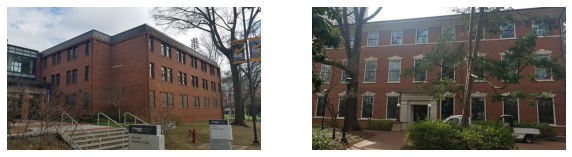

In [63]:
while True:
    k = random.choice(list(img_dataset.keys()))
    if len(img_dataset[k]['img_posFacts']) == 2 and img_dataset[k]['Qcate'] == 'Others':
        break
#k = '23948'
print(k)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
print(img_dataset[k]['Q'])
pprint(img_dataset[k]['A'])
for ax, f in zip(axes.ravel(), img_dataset[k]['img_posFacts']):
    im = PILImage.open("/data/yingshac/MMMHQA/gold_test/{}.jpg".format(f['image_id']))

    ax.imshow(im)
    ax.axis('off')
    print(f['url'])
    print(f['caption'])
    print(f['image_id'])
for f in img_dataset[k]['img_negFacts']:
    print(f['caption'])
    print(f['imgUrl'])
for f in img_dataset[k]['txt_negFacts']:
    print(f['fact'])
